In [ ]:
!pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.4 MB/s eta 0:00:00


[I 2025-04-08 18:45:20,329] A new study created in memory with name: no-name-ebeb6fa5-37ba-4fa5-af58-7d474d991d10
[I 2025-04-08 18:45:20,481] Trial 0 finished with value: 12.783307951719022 and parameters: {'model': 'xgb', 'n_estimators': 200, 'learning_rate': 0.05813475207015455, 'max_depth': 3}. Best is trial 0 with value: 12.783307951719022.
[I 2025-04-08 18:45:20,659] Trial 1 finished with value: 12.90747365612669 and parameters: {'model': 'xgb', 'n_estimators': 200, 'learning_rate': 0.10133110789030439, 'max_depth': 5}. Best is trial 0 with value: 12.783307951719022.
[I 2025-04-08 18:45:20,669] Trial 2 finished with value: 12.810391529118224 and parameters: {'model': 'ridge', 'alpha': 9.179890950313634}. Best is trial 0 with value: 12.783307951719022.
[I 2025-04-08 18:45:20,673] Trial 3 finished with value: 12.809991390336995 and parameters: {'model': 'ridge', 'alpha': 0.32908136758575707}. Best is trial 0 with value: 12.783307951719022.
[I 2025-04-08 18:45:20,717] Trial 4 finishe


XGB Model:
MAE: 13.13
RMSE: 16.25
R²: 0.27

RF Model:
MAE: 12.66
RMSE: 15.48
R²: 0.34

SVR Model:
MAE: 13.87
RMSE: 16.37
R²: 0.26

DT Model:
MAE: 12.86
RMSE: 16.47
R²: 0.25

LR Model:
MAE: 13.58
RMSE: 16.53
R²: 0.24

Stacking Ensemble Model:
MAE: 12.63
RMSE: 15.64
R²: 0.32


<ipython-input-2-775f1024dae3>:206: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")


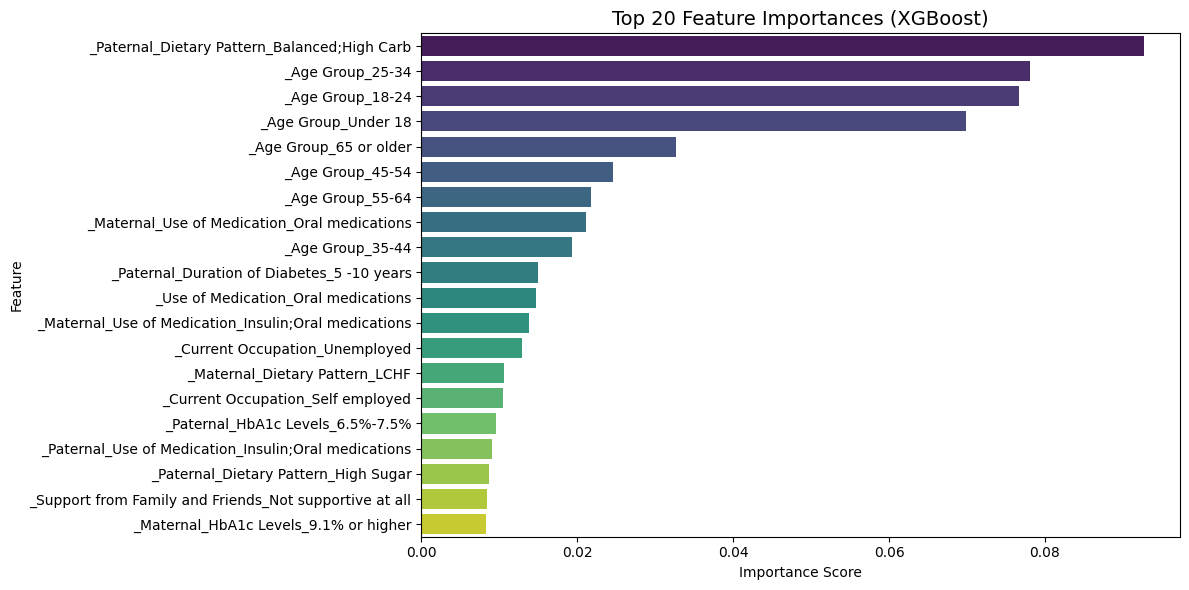

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel("/content/updated_current.xlsx")

# Convert Age at Diagnosis to numeric
def age_to_numeric(x):
    mapping = {'Under 18': 9, '18-34': 26, '35-44': 39.5, '45-54': 49.5, '55 or older': 60}
    return mapping.get(x, np.nan)

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)
df = df.dropna(subset=['Age_at_Diagnosis_numeric'])

# Clean numeric column
df['Average Blood sugar in 3 months'] = pd.to_numeric(df['Average Blood sugar in 3 months'], errors='coerce')

X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering
def create_features(data):
    data = data.copy()
    data['BMI'] = data['Weight'] / ((data['Height'] / 100) ** 2)
    data['Weight_Height_Ratio'] = data['Weight'] / data['Height']

    def hba1c_to_numeric(x):
        mapping = {'Below 5.7%': 5.35, '5.7%-6.4%': 6.05, '6.5%-7.5%': 7.0, '7.6%-9.0%': 8.3, '9.1% or higher': 9.5}
        return mapping.get(x, np.nan)

    data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    data['BMI_HbA1c_Interaction'] = data['BMI'] * data['HbA1c_numeric']
    data.drop(columns=['Height'], inplace=True, errors='ignore')
    return data

X_train = create_features(X_train)
X_test = create_features(X_test)

# Column Types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
manual_features = ['BMI', 'HbA1c_numeric', 'Weight_Height_Ratio', 'BMI_HbA1c_Interaction']
numeric_features = [f for f in numeric_features if f not in manual_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

manual_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('manual', manual_transformer, manual_features)
])

# Base models
base_models = {
    "xgb": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42),
    "rf": RandomForestRegressor(n_estimators=200, random_state=42),
    "svr": SVR(kernel='rbf', C=10, epsilon=0.1),
    "dt": DecisionTreeRegressor(max_depth=5, random_state=42),
    "lr": LinearRegression()
}


# Generate Out-of-Fold Predictions for Training Meta-Learner
def get_oof_predictions(model, X, y, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_train = np.zeros(len(X))
    oof_test = np.zeros(len(X_test))
    oof_test_folds = np.empty((n_splits, len(X_test)))

    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        pipeline.fit(X_tr, y_tr)
        oof_train[val_idx] = pipeline.predict(X_val)
        oof_test_folds[i, :] = pipeline.predict(X_test)

    oof_test[:] = oof_test_folds.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generate OOF predictions
stack_train_parts, stack_test_parts = [], []

for name, model in base_models.items():
    oof_train, oof_test = get_oof_predictions(model, X_train, y_train, X_test)
    stack_train_parts.append(oof_train)
    stack_test_parts.append(oof_test)

stack_train = np.hstack(stack_train_parts)
stack_test = np.hstack(stack_test_parts)

# Meta-Learner Optimization
def meta_objective(trial):
    model_type = trial.suggest_categorical("model", ["ridge", "xgb"])

    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 0.01, 10.0, log=True)
        meta_model = Ridge(alpha=alpha)
    else:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
        }
        meta_model = XGBRegressor(**params, random_state=42)

    meta_model.fit(stack_train, y_train)
    pred = meta_model.predict(stack_test)
    return mean_absolute_error(y_test, pred)

study = optuna.create_study(direction="minimize")
study.optimize(meta_objective, n_trials=30)
best_meta_params = study.best_params

# Final Meta Model
if best_meta_params["model"] == "ridge":
    final_meta_model = Ridge(alpha=best_meta_params["alpha"])
else:
    final_meta_model = XGBRegressor(
        n_estimators=best_meta_params["n_estimators"],
        learning_rate=best_meta_params["learning_rate"],
        max_depth=best_meta_params["max_depth"],
        random_state=42
    )

# Train final model and evaluate
final_meta_model.fit(stack_train, y_train)
final_pred = final_meta_model.predict(stack_test)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Model:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Base models direct prediction
for name, model in base_models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    evaluate_model(name.upper(), y_test, preds)

# Final stacked model
evaluate_model("Stacking Ensemble", y_test, final_pred)


# Fit XGBoost model pipeline
xgb_model = base_models["xgb"]
xgb_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', xgb_model)])
xgb_pipeline.fit(X_train, y_train)

# Extract raw feature names
feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Clean feature names (remove 'cat_', 'num', 'manual_' prefixes)
cleaned_feature_names = [name.replace("cat_", "").replace("num", "").replace("manual_", "") for name in feature_names]

# Extract importances
importances = xgb_pipeline.named_steps['regressor'].feature_importances_

# Create Pandas Series
feat_imp = pd.Series(importances, index=cleaned_feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")
plt.title("Top 20 Feature Importances (XGBoost)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

[I 2025-04-08 18:48:57,942] A new study created in memory with name: no-name-caa83379-4a49-4e3a-9daa-5da0acb4dc8b
[I 2025-04-08 18:48:58,043] Trial 0 finished with value: 11.956741463714446 and parameters: {'model': 'xgb', 'n_estimators': 50, 'learning_rate': 0.16213173058822483, 'max_depth': 4}. Best is trial 0 with value: 11.956741463714446.
[I 2025-04-08 18:48:58,114] Trial 1 finished with value: 12.329407382132437 and parameters: {'model': 'xgb', 'n_estimators': 100, 'learning_rate': 0.03519528838660309, 'max_depth': 4}. Best is trial 0 with value: 11.956741463714446.
[I 2025-04-08 18:48:58,121] Trial 2 finished with value: 12.551476855815862 and parameters: {'model': 'ridge', 'alpha': 5.15947544926702}. Best is trial 0 with value: 11.956741463714446.
[I 2025-04-08 18:48:58,205] Trial 3 finished with value: 12.367602089334866 and parameters: {'model': 'xgb', 'n_estimators': 100, 'learning_rate': 0.17034380666668916, 'max_depth': 5}. Best is trial 0 with value: 11.956741463714446.
[


XGB Model:
MAE: 13.13
RMSE: 16.12
R²: 0.28

RF Model:
MAE: 12.55
RMSE: 15.45
R²: 0.34

SVR Model:
MAE: 14.04
RMSE: 16.99
R²: 0.20

DT Model:
MAE: 12.56
RMSE: 16.67
R²: 0.23

LR Model:
MAE: 15.30
RMSE: 17.69
R²: 0.13

Stacking Ensemble Model:
MAE: 11.90
RMSE: 15.29
R²: 0.35


<ipython-input-3-1a172086ec2b>:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")


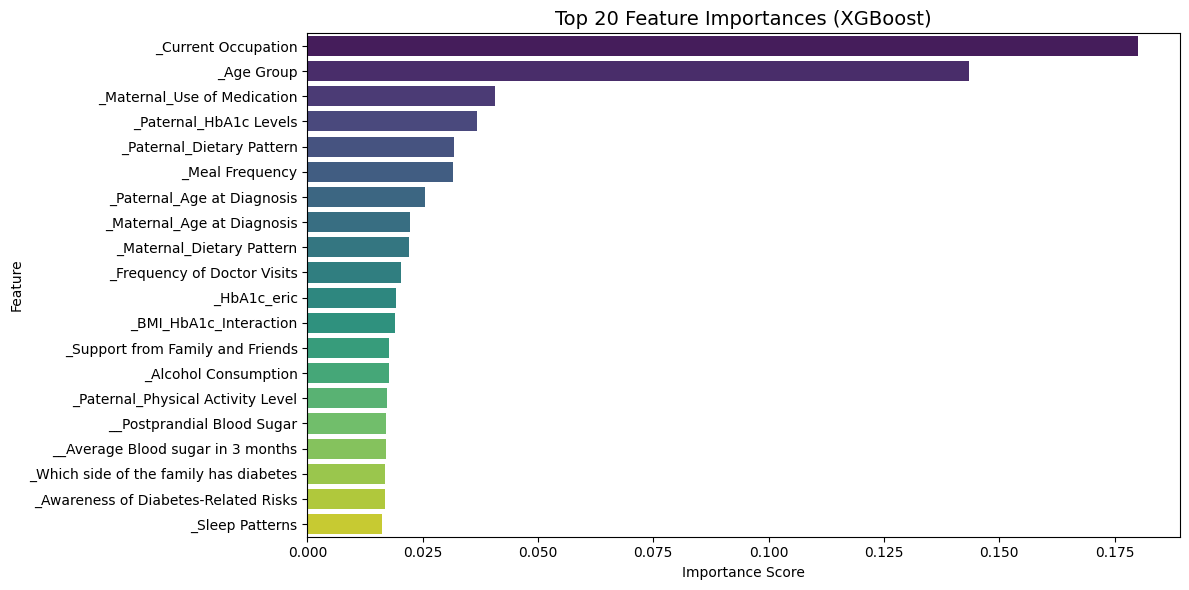

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel("/content/updated_current.xlsx")

# Convert Age at Diagnosis to numeric
def age_to_numeric(x):
    mapping = {'Under 18': 9, '18-34': 26, '35-44': 39.5, '45-54': 49.5, '55 or older': 60}
    return mapping.get(x, np.nan)

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)
df = df.dropna(subset=['Age_at_Diagnosis_numeric'])

# Clean numeric column
df['Average Blood sugar in 3 months'] = pd.to_numeric(df['Average Blood sugar in 3 months'], errors='coerce')

X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering
def create_features(data):
    data = data.copy()
    data['BMI'] = data['Weight'] / ((data['Height'] / 100) ** 2)
    data['Weight_Height_Ratio'] = data['Weight'] / data['Height']

    def hba1c_to_numeric(x):
        mapping = {'Below 5.7%': 5.35, '5.7%-6.4%': 6.05, '6.5%-7.5%': 7.0, '7.6%-9.0%': 8.3, '9.1% or higher': 9.5}
        return mapping.get(x, np.nan)

    data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    data['BMI_HbA1c_Interaction'] = data['BMI'] * data['HbA1c_numeric']
    data.drop(columns=['Height'], inplace=True, errors='ignore')
    return data

X_train = create_features(X_train)
X_test = create_features(X_test)

# Column Types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
manual_features = ['BMI', 'HbA1c_numeric', 'Weight_Height_Ratio', 'BMI_HbA1c_Interaction']
numeric_features = [f for f in numeric_features if f not in manual_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 🟢 REPLACED OneHotEncoder with OrdinalEncoder
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

manual_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('manual', manual_transformer, manual_features)
])

# Base models
base_models = {
    "xgb": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42),
    "rf": RandomForestRegressor(n_estimators=200, random_state=42),
    "svr": SVR(kernel='rbf', C=10, epsilon=0.1),
    "dt": DecisionTreeRegressor(max_depth=5, random_state=42),
    "lr": LinearRegression()
}

# Generate Out-of-Fold Predictions for Training Meta-Learner
def get_oof_predictions(model, X, y, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_train = np.zeros(len(X))
    oof_test = np.zeros(len(X_test))
    oof_test_folds = np.empty((n_splits, len(X_test)))

    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        pipeline.fit(X_tr, y_tr)
        oof_train[val_idx] = pipeline.predict(X_val)
        oof_test_folds[i, :] = pipeline.predict(X_test)

    oof_test[:] = oof_test_folds.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generate OOF predictions
stack_train_parts, stack_test_parts = [], []

for name, model in base_models.items():
    oof_train, oof_test = get_oof_predictions(model, X_train, y_train, X_test)
    stack_train_parts.append(oof_train)
    stack_test_parts.append(oof_test)

stack_train = np.hstack(stack_train_parts)
stack_test = np.hstack(stack_test_parts)

# Meta-Learner Optimization
def meta_objective(trial):
    model_type = trial.suggest_categorical("model", ["ridge", "xgb"])

    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 0.01, 10.0, log=True)
        meta_model = Ridge(alpha=alpha)
    else:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
        }
        meta_model = XGBRegressor(**params, random_state=42)

    meta_model.fit(stack_train, y_train)
    pred = meta_model.predict(stack_test)
    return mean_absolute_error(y_test, pred)

study = optuna.create_study(direction="minimize")
study.optimize(meta_objective, n_trials=30)
best_meta_params = study.best_params

# Final Meta Model
if best_meta_params["model"] == "ridge":
    final_meta_model = Ridge(alpha=best_meta_params["alpha"])
else:
    final_meta_model = XGBRegressor(
        n_estimators=best_meta_params["n_estimators"],
        learning_rate=best_meta_params["learning_rate"],
        max_depth=best_meta_params["max_depth"],
        random_state=42
    )

# Train final model and evaluate
final_meta_model.fit(stack_train, y_train)
final_pred = final_meta_model.predict(stack_test)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Model:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Base models direct prediction
for name, model in base_models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    evaluate_model(name.upper(), y_test, preds)

# Final stacked model
evaluate_model("Stacking Ensemble", y_test, final_pred)

# Fit XGBoost model pipeline
xgb_model = base_models["xgb"]
xgb_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', xgb_model)])
xgb_pipeline.fit(X_train, y_train)

# Extract raw feature names
feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Clean feature names (remove 'cat_', 'num', 'manual_' prefixes)
cleaned_feature_names = [name.replace("cat_", "").replace("num", "").replace("manual_", "") for name in feature_names]

# Extract importances
importances = xgb_pipeline.named_steps['regressor'].feature_importances_

# Create Pandas Series
feat_imp = pd.Series(importances, index=cleaned_feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")
plt.title("Top 20 Feature Importances (XGBoost)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['HbA1c_numeric' 'BMI_HbA1c_Interaction']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['HbA1c_numeric' 'BMI_HbA1c_Interaction']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['HbA1c_numeric' 'BMI_HbA1c_Interaction']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['HbA1c_numeric' 'BMI_HbA1c_Interaction']. At least one non-miss


XGB Model:
MAE: 13.00
RMSE: 16.37
R²: 0.26


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['HbA1c_numeric' 'BMI_HbA1c_Interaction']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['HbA1c_numeric' 'BMI_HbA1c_Interaction']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['HbA1c_numeric' 'BMI_HbA1c_Interaction']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['HbA1c_numeric' 'BMI_HbA1c_Interaction']. At least one non-miss


RF Model:
MAE: 12.83
RMSE: 15.74
R²: 0.31

SVR Model:
MAE: 14.43
RMSE: 17.37
R²: 0.16

DT Model:
MAE: 13.50
RMSE: 17.58
R²: 0.14

LR Model:
MAE: 14.83
RMSE: 17.29
R²: 0.17

Stacking Ensemble Model:
MAE: 12.67
RMSE: 15.61
R²: 0.32


<ipython-input-4-060256217851>:207: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")


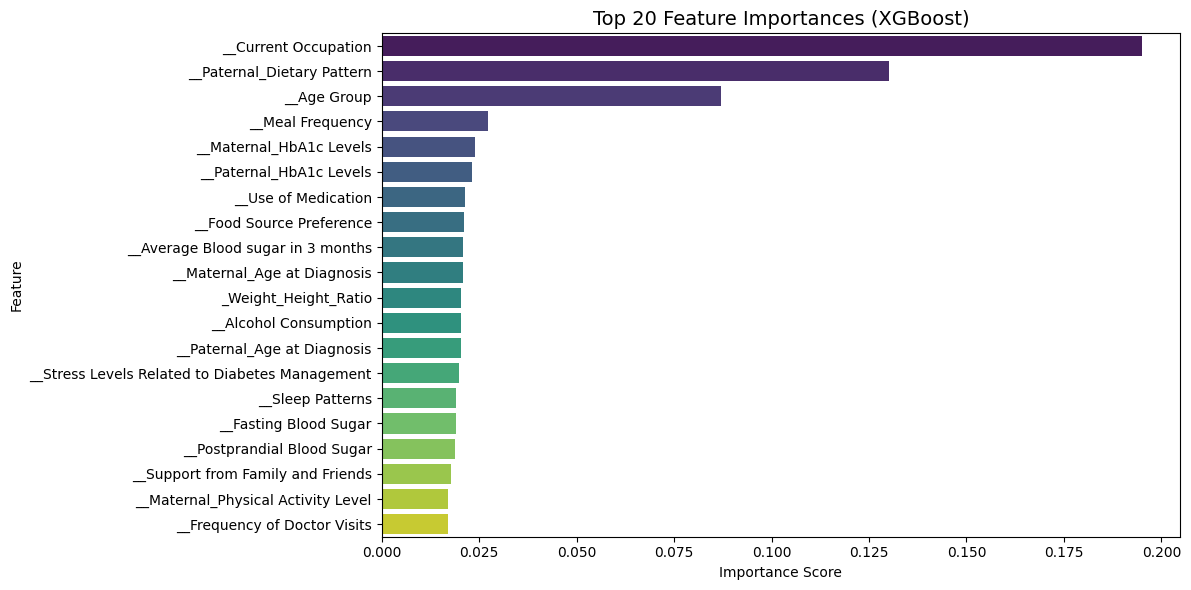

In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the Excel file
file_path = '/content/updated_current.xlsx'
df = pd.read_excel(file_path)

# Step 2: Convert Age at Diagnosis to numeric
def age_to_numeric(x):
    mapping = {'Under 18': 9, '18-34': 26, '35-44': 39.5, '45-54': 49.5, '55 or older': 60}
    return mapping.get(x, np.nan)

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)
df = df.dropna(subset=['Age_at_Diagnosis_numeric'])

# Step 3: Clean numeric column
df['Average Blood sugar in 3 months'] = pd.to_numeric(df['Average Blood sugar in 3 months'], errors='coerce')

# Step 4: Label Encoding categorical features
from sklearn.preprocessing import LabelEncoder
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Step 5: Define features and target
X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering
def create_features(data):
    data = data.copy()
    data['BMI'] = data['Weight'] / ((data['Height'] / 100) ** 2)
    data['Weight_Height_Ratio'] = data['Weight'] / data['Height']

    def hba1c_to_numeric(x):
        mapping = {'Below 5.7%': 5.35, '5.7%-6.4%': 6.05, '6.5%-7.5%': 7.0, '7.6%-9.0%': 8.3, '9.1% or higher': 9.5}
        return mapping.get(x, np.nan)

    if 'HbA1c Levels' in data.columns:
        data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    data['BMI_HbA1c_Interaction'] = data['BMI'] * data['HbA1c_numeric']
    data.drop(columns=['Height'], inplace=True, errors='ignore')
    return data

X_train = create_features(X_train)
X_test = create_features(X_test)

# Column Types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = []
manual_features = ['BMI', 'HbA1c_numeric', 'Weight_Height_Ratio', 'BMI_HbA1c_Interaction']
numeric_features = [f for f in numeric_features if f not in manual_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

manual_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('manual', manual_transformer, manual_features)
])

# Base models
base_models = {
    "xgb": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42),
    "rf": RandomForestRegressor(n_estimators=200, random_state=42),
    "svr": SVR(kernel='rbf', C=10, epsilon=0.1),
    "dt": DecisionTreeRegressor(max_depth=5, random_state=42),
    "lr": LinearRegression()
}

# Generate Out-of-Fold Predictions for Training Meta-Learner
def get_oof_predictions(model, X, y, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_train = np.zeros(len(X))
    oof_test = np.zeros(len(X_test))
    oof_test_folds = np.empty((n_splits, len(X_test)))

    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        pipeline.fit(X_tr, y_tr)
        oof_train[val_idx] = pipeline.predict(X_val)
        oof_test_folds[i, :] = pipeline.predict(X_test)

    oof_test[:] = oof_test_folds.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generate OOF predictions
stack_train_parts, stack_test_parts = [], []
for name, model in base_models.items():
    oof_train, oof_test = get_oof_predictions(model, X_train, y_train, X_test)
    stack_train_parts.append(oof_train)
    stack_test_parts.append(oof_test)

stack_train = np.hstack(stack_train_parts)
stack_test = np.hstack(stack_test_parts)

# Meta-Learner Optimization
def meta_objective(trial):
    model_type = trial.suggest_categorical("model", ["ridge", "xgb"])
    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 0.01, 10.0, log=True)
        meta_model = Ridge(alpha=alpha)
    else:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
        }
        meta_model = XGBRegressor(**params, random_state=42)

    meta_model.fit(stack_train, y_train)
    pred = meta_model.predict(stack_test)
    return mean_absolute_error(y_test, pred)

study = optuna.create_study(direction="minimize")
study.optimize(meta_objective, n_trials=30)
best_meta_params = study.best_params

# Final Meta Model
if best_meta_params["model"] == "ridge":
    final_meta_model = Ridge(alpha=best_meta_params["alpha"])
else:
    final_meta_model = XGBRegressor(
        n_estimators=best_meta_params["n_estimators"],
        learning_rate=best_meta_params["learning_rate"],
        max_depth=best_meta_params["max_depth"],
        random_state=42
    )

# Train final model and evaluate
final_meta_model.fit(stack_train, y_train)
final_pred = final_meta_model.predict(stack_test)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Model:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Base models direct prediction
for name, model in base_models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    evaluate_model(name.upper(), y_test, preds)

# Final stacked model
evaluate_model("Stacking Ensemble", y_test, final_pred)

# Fit XGBoost model pipeline
xgb_model = base_models["xgb"]
xgb_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', xgb_model)])
xgb_pipeline.fit(X_train, y_train)

# Extract raw feature names
feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Clean feature names
cleaned_feature_names = [name.replace("cat_", "").replace("num", "").replace("manual_", "") for name in feature_names]

# Extract importances
importances = xgb_pipeline.named_steps['regressor'].feature_importances_

# Create Pandas Series
feat_imp = pd.Series(importances, index=cleaned_feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")
plt.title("Top 20 Feature Importances (XGBoost)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


[I 2025-04-08 19:20:51,406] A new study created in memory with name: no-name-fc87d3cb-89e1-4158-94e0-1b7a0a502d6d
[I 2025-04-08 19:20:51,532] Trial 0 finished with value: 0.09955873339967336 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.09955873339967336.
[I 2025-04-08 19:20:51,621] Trial 1 finished with value: 0.12078532101629413 and parameters: {'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': None}. Best is trial 1 with value: 0.12078532101629413.
[I 2025-04-08 19:20:51,695] Trial 2 finished with value: 0.012202095191876317 and parameters: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 1 with value: 0.12078532101629413.
[I 2025-04-08 19:20:51,797] Trial 3 finished with value: -0.0722554841909373 and parameters: {'max_depth': 18, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is


RF Model:
MAE: 12.55
RMSE: 15.45
R²: 0.34

XGB Model:
MAE: 13.13
RMSE: 16.12
R²: 0.28

SVR Model:
MAE: 14.04
RMSE: 16.99
R²: 0.20

DT Model:
MAE: 12.59
RMSE: 15.88
R²: 0.30

LR Model:
MAE: 15.30
RMSE: 17.69
R²: 0.13


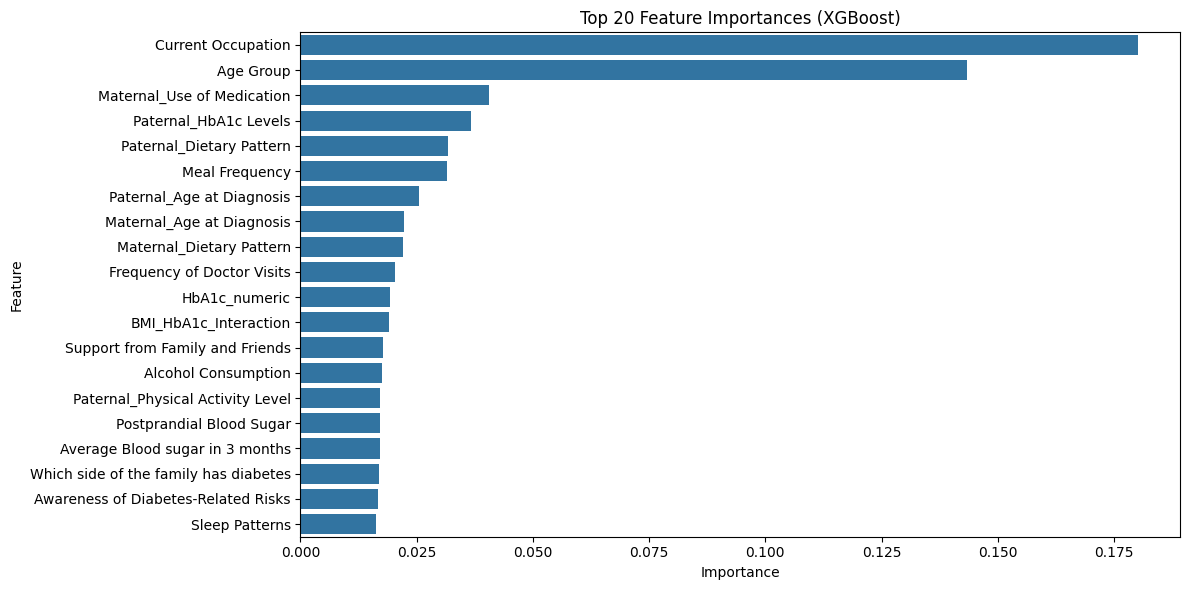


🔁 Stacking Stage 1: ['rf', 'xgb']

Stacking Stage 1 Model:
MAE: 12.63
RMSE: 15.42
R²: 0.34

🔁 Stacking Stage 2: ['rf', 'xgb', 'svr']

Stacking Stage 2 Model:
MAE: 12.61
RMSE: 15.40
R²: 0.34

🔁 Stacking Stage 3: ['rf', 'xgb', 'svr', 'dt']

Stacking Stage 3 Model:
MAE: 12.61
RMSE: 15.40
R²: 0.34

🔁 Stacking Stage 4: ['rf', 'xgb', 'svr', 'dt', 'lr']

Stacking Stage 4 Model:
MAE: 12.54
RMSE: 15.40
R²: 0.34


In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel("/content/updated_current.xlsx")

# Convert Age at Diagnosis to numeric
def age_to_numeric(x):
    mapping = {'Under 18': 9, '18-34': 26, '35-44': 39.5, '45-54': 49.5, '55 or older': 60}
    return mapping.get(x, np.nan)

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)
df = df.dropna(subset=['Age_at_Diagnosis_numeric'])

# Clean numeric column
df['Average Blood sugar in 3 months'] = pd.to_numeric(df['Average Blood sugar in 3 months'], errors='coerce')

X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering
def create_features(data):
    data = data.copy()
    data['BMI'] = data['Weight'] / ((data['Height'] / 100) ** 2)
    data['Weight_Height_Ratio'] = data['Weight'] / data['Height']

    def hba1c_to_numeric(x):
        mapping = {'Below 5.7%': 5.35, '5.7%-6.4%': 6.05, '6.5%-7.5%': 7.0, '7.6%-9.0%': 8.3, '9.1% or higher': 9.5}
        return mapping.get(x, np.nan)

    data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    data['BMI_HbA1c_Interaction'] = data['BMI'] * data['HbA1c_numeric']
    data.drop(columns=['Height'], inplace=True, errors='ignore')
    return data

X_train = create_features(X_train)
X_test = create_features(X_test)

# Column Types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
manual_features = ['BMI', 'HbA1c_numeric', 'Weight_Height_Ratio', 'BMI_HbA1c_Interaction']
numeric_features = [f for f in numeric_features if f not in manual_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

manual_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('manual', manual_transformer, manual_features)
])

# Optimize Decision Tree with Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model = DecisionTreeRegressor(random_state=42, **params)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    return r2_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_dt = DecisionTreeRegressor(random_state=42, **study.best_params)

# Define all models
all_models = {
    "rf": RandomForestRegressor(n_estimators=200, random_state=42),
    "xgb": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42),
    "svr": SVR(kernel='rbf', C=10, epsilon=0.1),
    "dt": best_dt,
    "lr": LinearRegression()
}

# Function to evaluate models
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Model:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Evaluate individual base models
for name, model in all_models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    evaluate_model(name.upper(), y_test, preds)

# Feature importance for XGB
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', all_models['xgb'])
])
xgb_model.fit(X_train, y_train)
all_features = numeric_features + categorical_features + manual_features
importances = xgb_model.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

# Define stacking stages
stacking_stages = [
    ["rf", "xgb"],
    ["rf", "xgb", "svr"],
    ["rf", "xgb", "svr", "dt"],
    ["rf", "xgb", "svr", "dt", "lr"]
]

# Function to get OOF predictions
def get_oof_predictions(model, X, y, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_train = np.zeros(len(X))
    oof_test = np.zeros(len(X_test))
    oof_test_folds = np.empty((n_splits, len(X_test)))

    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        pipeline.fit(X_tr, y_tr)
        oof_train[val_idx] = pipeline.predict(X_val)
        oof_test_folds[i, :] = pipeline.predict(X_test)

    oof_test[:] = oof_test_folds.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Run stacking for each stage
for stage_num, model_keys in enumerate(stacking_stages, start=1):
    print(f"\n🔁 Stacking Stage {stage_num}: {model_keys}")

    stack_train_parts, stack_test_parts = [], []

    for key in model_keys:
        model = all_models[key]
        oof_train, oof_test = get_oof_predictions(model, X_train, y_train, X_test)
        stack_train_parts.append(oof_train)
        stack_test_parts.append(oof_test)

    stack_train = np.hstack(stack_train_parts)
    stack_test = np.hstack(stack_test_parts)

    meta_model = Ridge(alpha=1.0)
    meta_model.fit(stack_train, y_train)
    final_pred = meta_model.predict(stack_test)

    evaluate_model(f"Stacking Stage {stage_num}", y_test, final_pred)


[I 2025-04-08 20:17:14,804] A new study created in memory with name: no-name-d4e0aa2c-72f0-413f-a6a5-0e43b75dcdd8
[I 2025-04-08 20:17:14,850] Trial 0 finished with value: -0.013799034250095321 and parameters: {'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 0 with value: -0.013799034250095321.
[I 2025-04-08 20:17:14,910] Trial 1 finished with value: -0.38683969071308133 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None}. Best is trial 0 with value: -0.013799034250095321.
[I 2025-04-08 20:17:14,953] Trial 2 finished with value: 0.1640330998227969 and parameters: {'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.1640330998227969.
[I 2025-04-08 20:17:15,014] Trial 3 finished with value: -0.2922966934802431 and parameters: {'max_depth': 20, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': None}. Best is


XGB Model:
MAE: 12.88, RMSE: 16.15, R²: 0.28

RF Model:
MAE: 12.81, RMSE: 15.68, R²: 0.32

SVR Model:
MAE: 14.43, RMSE: 17.32, R²: 0.17

DT Model:
MAE: 14.67, RMSE: 17.36, R²: 0.16

LR Model:
MAE: 14.84, RMSE: 17.29, R²: 0.17

Stacking Ensemble Model:
MAE: 12.58, RMSE: 15.81, R²: 0.31


<ipython-input-21-921ad8c4f74c>:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")


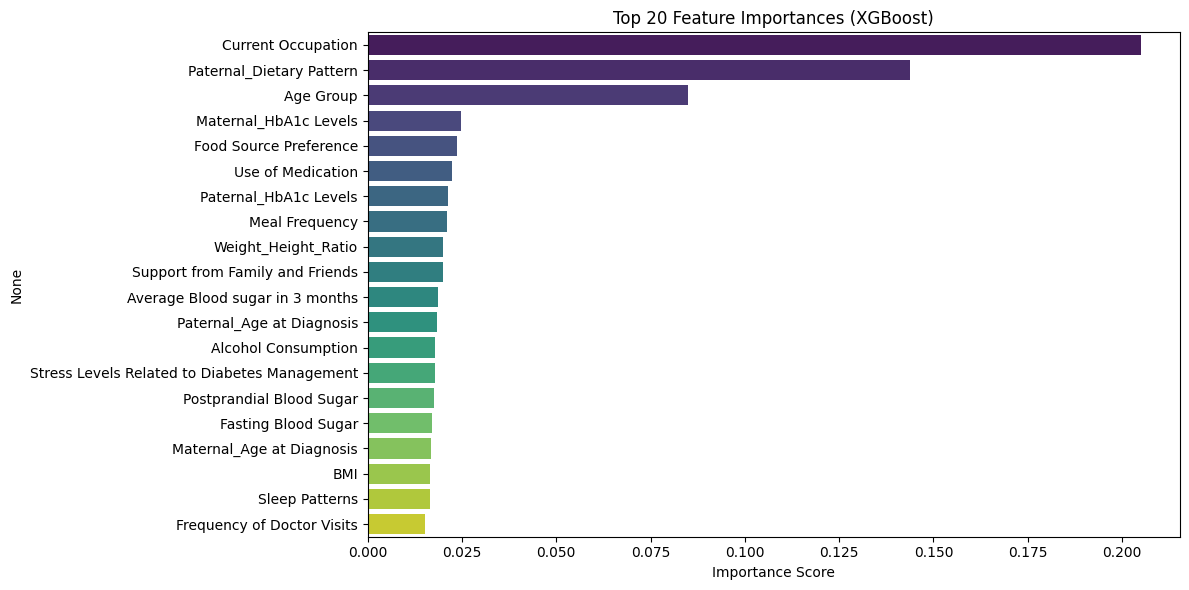

In [ ]:
print("Missing in HbA1c_numeric:", X_train['HbA1c_numeric'].isnull().sum())
print("Missing in BMI_HbA1c_Interaction:", X_train['BMI_HbA1c_Interaction'].isnull().sum())

Missing in HbA1c_numeric: 0
Missing in BMI_HbA1c_Interaction: 0


[I 2025-04-08 20:21:19,368] A new study created in memory with name: no-name-27d69b10-2442-489b-ac84-7bdfb23c4532
[I 2025-04-08 20:21:19,415] Trial 0 finished with value: 0.04370394832939206 and parameters: {'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 0 with value: 0.04370394832939206.
[I 2025-04-08 20:21:19,454] Trial 1 finished with value: -0.14826578983678296 and parameters: {'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.04370394832939206.
[I 2025-04-08 20:21:19,492] Trial 2 finished with value: 0.028499288190208416 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.04370394832939206.
[I 2025-04-08 20:21:19,531] Trial 3 finished with value: -0.3081143115456233 and parameters: {'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is


XGB Model:
MAE: 12.88
RMSE: 16.15
R²: 0.28

RF Model:
MAE: 12.81
RMSE: 15.68
R²: 0.32

SVR Model:
MAE: 14.43
RMSE: 17.32
R²: 0.17

DT Model:
MAE: 13.47
RMSE: 17.50
R²: 0.15

LR Model:
MAE: 14.84
RMSE: 17.29
R²: 0.17

Stacking Ensemble Model:
MAE: 12.38
RMSE: 15.48
R²: 0.34


<ipython-input-23-5fcc52fa078f>:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")


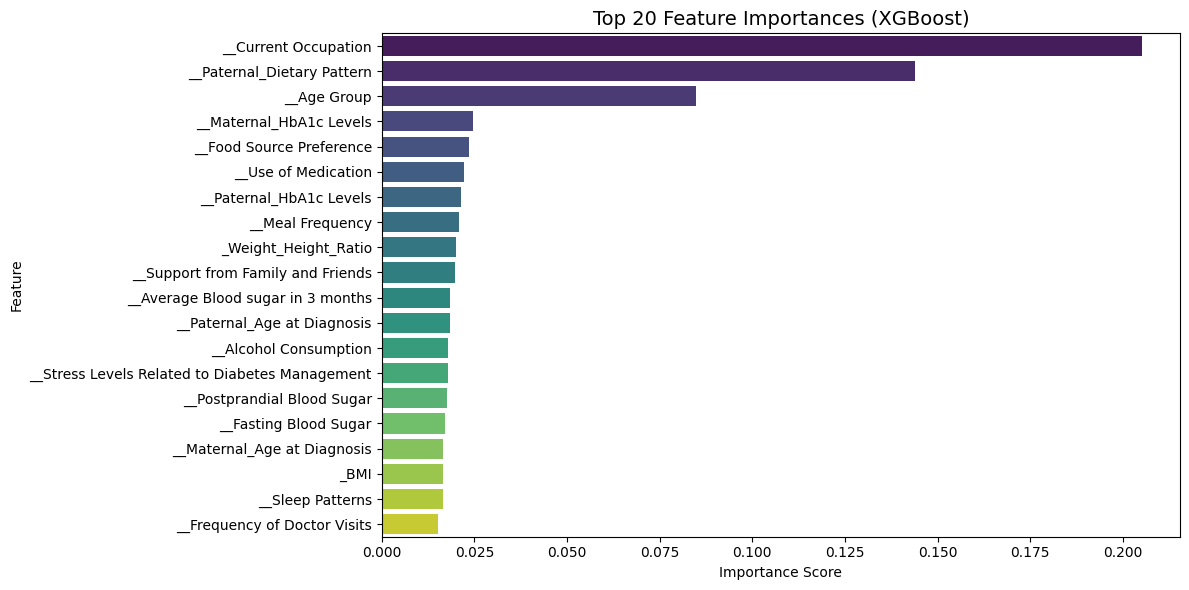


🔁 Stacking Stage 1: ['rf', 'xgb']

Stacking Stage 1 Model:
MAE: 12.86
RMSE: 15.58
R²: 0.33

🔁 Stacking Stage 2: ['rf', 'xgb', 'svr']

Stacking Stage 2 Model:
MAE: 12.88
RMSE: 15.59
R²: 0.33

🔁 Stacking Stage 3: ['rf', 'xgb', 'svr', 'dt']

Stacking Stage 3 Model:
MAE: 12.88
RMSE: 15.60
R²: 0.33

🔁 Stacking Stage 4: ['rf', 'xgb', 'svr', 'dt', 'lr']

Stacking Stage 4 Model:
MAE: 12.87
RMSE: 15.62
R²: 0.32


In [ ]:
import pandas as pd
import numpy as np
import optuna
from sklearn.model_selection import train_test_split, KFold
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the Excel file
file_path = '/content/updated_current.xlsx'
df = pd.read_excel(file_path)

# Step 2: Convert Age at Diagnosis to numeric
def age_to_numeric(x):
    mapping = {'Under 18': 9, '18-34': 26, '35-44': 39.5, '45-54': 49.5, '55 or older': 60}
    return mapping.get(x, np.nan)

df['Age_at_Diagnosis_numeric'] = df['Age at Diagnosis'].apply(age_to_numeric)
df = df.dropna(subset=['Age_at_Diagnosis_numeric'])

# Step 3: Clean numeric column
df['Average Blood sugar in 3 months'] = pd.to_numeric(df['Average Blood sugar in 3 months'], errors='coerce')

# Step 4: Label Encoding categorical features
from sklearn.preprocessing import LabelEncoder
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Step 5: Define features and target
X = df.drop(columns=['Age at Diagnosis', 'Age_at_Diagnosis_numeric'])
y = df['Age_at_Diagnosis_numeric']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Engineering
def create_features(data):
    data = data.copy()
    data['BMI'] = data['Weight'] / ((data['Height'] / 100) ** 2)
    data['Weight_Height_Ratio'] = data['Weight'] / data['Height']

    def hba1c_to_numeric(x):
        if pd.isna(x):
            return np.nan
        if isinstance(x, str):
            x = x.strip().lower()
            if 'below' in x:
                return 5.35
            elif '5.7' in x and '6.4' in x:
                return 6.05
            elif '6.5' in x and '7.5' in x:
                return 7.0
            elif '7.6' in x and '9.0' in x:
                return 8.3
            elif '9.1' in x or 'higher' in x:
                return 9.5
        return x

    if 'HbA1c Levels' in data.columns:
        data['HbA1c_numeric'] = data['HbA1c Levels'].apply(hba1c_to_numeric)
    data['BMI_HbA1c_Interaction'] = data['BMI'] * data['HbA1c_numeric']
    data.drop(columns=['Height'], inplace=True, errors='ignore')
    return data

X_train = create_features(X_train)
X_test = create_features(X_test)

# Column Types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = []
manual_features = ['BMI', 'HbA1c_numeric', 'Weight_Height_Ratio', 'BMI_HbA1c_Interaction']
numeric_features = [f for f in numeric_features if f not in manual_features]

# Preprocessing Pipelines
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

manual_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('manual', manual_transformer, manual_features)
])

# Optimize Decision Tree with Optuna (krna pada coz negetive aa rha tha)
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    }
    model = DecisionTreeRegressor(random_state=42, **params)
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    return r2_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

best_dt = DecisionTreeRegressor(random_state=42, **study.best_params)

# Base models
base_models = {
    "xgb": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5, random_state=42),
    "rf": RandomForestRegressor(n_estimators=200, random_state=42),
    "svr": SVR(kernel='rbf', C=10, epsilon=0.1),
    "dt": DecisionTreeRegressor(max_depth=5, random_state=42),
    "lr": LinearRegression()
}

# Generate Out-of-Fold Predictions for Training Meta-Learner
def get_oof_predictions(model, X, y, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_train = np.zeros(len(X))
    oof_test = np.zeros(len(X_test))
    oof_test_folds = np.empty((n_splits, len(X_test)))

    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        pipeline.fit(X_tr, y_tr)
        oof_train[val_idx] = pipeline.predict(X_val)
        oof_test_folds[i, :] = pipeline.predict(X_test)

    oof_test[:] = oof_test_folds.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Generate OOF predictions
stack_train_parts, stack_test_parts = [], []
for name, model in base_models.items():
    oof_train, oof_test = get_oof_predictions(model, X_train, y_train, X_test)
    stack_train_parts.append(oof_train)
    stack_test_parts.append(oof_test)

stack_train = np.hstack(stack_train_parts)
stack_test = np.hstack(stack_test_parts)

# Meta-Learner Optimization
def meta_objective(trial):
    model_type = trial.suggest_categorical("model", ["ridge", "xgb"])
    if model_type == "ridge":
        alpha = trial.suggest_float("alpha", 0.01, 10.0, log=True)
        meta_model = Ridge(alpha=alpha)
    else:
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=50),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
            "max_depth": trial.suggest_int("max_depth", 2, 6),
        }
        meta_model = XGBRegressor(**params, random_state=42)

    meta_model.fit(stack_train, y_train)
    pred = meta_model.predict(stack_test)
    return mean_absolute_error(y_test, pred)

study = optuna.create_study(direction="minimize")
study.optimize(meta_objective, n_trials=30)
best_meta_params = study.best_params

# Final Meta Model
if best_meta_params["model"] == "ridge":
    final_meta_model = Ridge(alpha=best_meta_params["alpha"])
else:
    final_meta_model = XGBRegressor(
        n_estimators=best_meta_params["n_estimators"],
        learning_rate=best_meta_params["learning_rate"],
        max_depth=best_meta_params["max_depth"],
        random_state=42
    )

# Train final model and evaluate
final_meta_model.fit(stack_train, y_train)
final_pred = final_meta_model.predict(stack_test)

# Evaluation
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Model:")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Base models direct prediction
for name, model in base_models.items():
    pipe = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    evaluate_model(name.upper(), y_test, preds)

# Final stacked model
evaluate_model("Stacking Ensemble", y_test, final_pred)

# Fit XGBoost model pipeline
xgb_model = base_models["xgb"]
xgb_pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', xgb_model)])
xgb_pipeline.fit(X_train, y_train)

# Extract raw feature names
feature_names = xgb_pipeline.named_steps['preprocessor'].get_feature_names_out()

# Clean feature names
cleaned_feature_names = [name.replace("cat_", "").replace("num", "").replace("manual_", "") for name in feature_names]

# Extract importances
importances = xgb_pipeline.named_steps['regressor'].feature_importances_

# Create Pandas Series
feat_imp = pd.Series(importances, index=cleaned_feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=feat_imp.values[:20], y=feat_imp.index[:20], palette="viridis")
plt.title("Top 20 Feature Importances (XGBoost)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# Define stacking stages (idhr stcaking stages separately define hue hain)
stacking_stages = [
    ["rf", "xgb"],
    ["rf", "xgb", "svr"],
    ["rf", "xgb", "svr", "dt"],
    ["rf", "xgb", "svr", "dt", "lr"]
]

# Function to get OOF predictions (this was done to overcome ipsi ka 1 R^2)
def get_oof_predictions(model, X, y, X_test, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    oof_train = np.zeros(len(X))
    oof_test = np.zeros(len(X_test))
    oof_test_folds = np.empty((n_splits, len(X_test)))

    for i, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', model)
        ])
        pipeline.fit(X_tr, y_tr)
        oof_train[val_idx] = pipeline.predict(X_val)
        oof_test_folds[i, :] = pipeline.predict(X_test)

    oof_test[:] = oof_test_folds.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

# Run stacking for each stage (idhr separately each tsacking combo ko run kiya hai)
for stage_num, model_keys in enumerate(stacking_stages, start=1):
    print(f"\n🔁 Stacking Stage {stage_num}: {model_keys}")

    stack_train_parts, stack_test_parts = [], []

    for key in model_keys:
        model = all_models[key]
        oof_train, oof_test = get_oof_predictions(model, X_train, y_train, X_test)
        stack_train_parts.append(oof_train)
        stack_test_parts.append(oof_test)

    stack_train = np.hstack(stack_train_parts)
    stack_test = np.hstack(stack_test_parts)

    meta_model = Ridge(alpha=1.0)
    meta_model.fit(stack_train, y_train)
    final_pred = meta_model.predict(stack_test)

    evaluate_model(f"Stacking Stage {stage_num}", y_test, final_pred)